In [90]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame

## example

```bash
nohup parallel 'python3 experiment_dbpedia_14.py --group_id dbpedia_14_20240109 --n_sample_from 5 --n_sample_to 25 --n_trials 10 --verification {1} --strategy {2}' ::: themselves dataset ::: normal super > results/ex_20240109.log &

In [91]:
group_id_list = ["truthfulqa_20240206_1", "truthfulqa_20240202"]

# load result
results = []
for group_id in group_id_list:
    result_files = glob.glob(f"./results/{group_id}/*.pickle")
    for file in result_files:
        with open(file, "rb") as f:
            tmp = pickle.load(f)
            # print("verification: ", tmp["args"].verification)
            # print("strategy: ", tmp["args"].strategy)
            if tmp["args"].verification == "themselves":
                results.append(tmp)

# create plots folder
os.makedirs(f"./plots/{group_id_list[0]}/", exist_ok=True)

print(results[0]["result"])

[[{'class label': 'Geography', 'TP': 10, 'TN': 10, 'FP': 0, 'FN': 0, 'precision': 1.0, 'negative examples': ['Earth Science', 'Cartography', 'Geology', 'Meteorology', 'Oceanography', 'Environmental Science', 'Geodesy', 'Geophysics', 'Climatology', 'Remote Sensing'], 'positive examples': ['mountain', 'river', 'ocean', 'desert', 'forest', 'island', 'valley', 'canyon', 'lake', 'peninsula'], 'accuracy': 1.0, 'n_samples': 10}, {'class label': 'Vacation policies', 'TP': 8, 'TN': 3, 'FP': 2, 'FN': 7, 'precision': 0.8, 'negative examples': ['Company policies', 'Employee benefits', 'Human resources policies', 'Workplace regulations', 'Labor laws', 'Employment contracts', 'Compensation packages', 'Leave policies', 'Time off policies', 'Paid time off'], 'positive examples': ['Unlimited PTO', 'Paid time off', 'Sick leave', 'Maternity leave', 'Paternity leave', 'Bereavement leave', 'Jury duty leave', 'Military leave', 'Sabbatical leave', 'Volunteer time off'], 'accuracy': 0.55, 'n_samples': 10}, {'

In [92]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "n_samples", "n_trials", "strategy"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    # if args.verification == "themselves" or strategy == "normal":
    #     continue
    for trial in r["result"]:
        for sample in trial:
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                strategy,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
# print("total #data should be:", 14*n_trials*5)
print(df_results.loc[0:14])

#data:  0
experiment settings:  Namespace(dataset='truthful_qa', group_id='truthfulqa_2024020206_1', n_trials=1, n_sample_from=10, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct-0914', logging=True, max_retry=3, test=False, strategy='super', verification='themselves', temperature=0.0, n_items=0)
#data:  1942
experiment settings:  Namespace(dataset='truthful_qa', group_id='truthfulqa_20240206_1', n_trials=1, n_sample_from=5, n_sample_to=5, n_sample_step=5, model='gpt-3.5-turbo-instruct-0914', logging=True, max_retry=3, test=False, strategy='super', verification='themselves', temperature=0.0, n_items=0)
#data:  2436
experiment settings:  Namespace(group_id='truthfulqa_20240202', n_trials=1, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct-0914', logging=True, max_retry=3, test=False, strategy='super', verification='themselves', temperature=0.0, n_items=0)
#data:  2436
experiment settings:  Namespace(group_id='truthfulqa_20240202', n_trials=1

In [93]:
# group by n_sample
res_g_sample = df_results.groupby(by=["n_samples"], as_index=False).mean(["accuracy", "precision"])

cor = res_g_sample[['n_samples', 'accuracy', 'precision']].corr()

res_g_sample = res_g_sample.drop(columns=["n_trials"])

print(res_g_sample.to_latex(escape=True,index=False))


print(cor.to_latex(escape=True))

\begin{tabular}{rrrrrrr}
\toprule
n\_samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.511888 & 0.721279 & 3.606394 & 1.512488 & 1.393606 & 3.487512 \\
10 & 0.468054 & 0.643330 & 6.433300 & 2.927783 & 3.566700 & 7.072217 \\
15 & 0.460141 & 0.631058 & 9.465863 & 4.338353 & 5.534137 & 10.661647 \\
20 & 0.441574 & 0.603633 & 12.072654 & 5.590313 & 7.927346 & 14.409687 \\
25 & 0.427039 & 0.584746 & 14.618661 & 6.733266 & 10.381339 & 18.266734 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & n\_samples & accuracy & precision \\
\midrule
n\_samples & 1.000000 & -0.960911 & -0.942075 \\
accuracy & -0.960911 & 1.000000 & 0.997654 \\
precision & -0.942075 & 0.997654 & 1.000000 \\
\bottomrule
\end{tabular}


In [94]:
def plot_acc_prec_summary(df: DataFrame, fontsize=12 , compare_with=0):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("n_samples")
    # plt.ylim(0, 1.05)
    
    for idx, (l, klass) in enumerate(df_target.groupby(by="strategy")):
        subplt = plt.subplot(1, 2, idx+1)
        subplt.set_title(l, fontsize=fontsize)
        subplt.set_ylim(0, 1.05)
        subplt.set_xlabel("n_samples", fontsize=fontsize)
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        for n_sample, data in klass.groupby(by="n_samples"):
            n_list.append(n_sample)
            precs_by_n_sample.append(data["precision"].mean())
            accs_by_n_sample.append(data["accuracy"].mean())
        subplt.plot(n_list, precs_by_n_sample, label="precision")
        subplt.plot(n_list, accs_by_n_sample, label="accuracy")
        subplt.set_xticks(n_list)
        subplt.set_xlim(min(n_list)-1, max(n_list)+1)
        if compare_with != 0:
            subplt.axhline(y=compare_with, color='gray', linestyle='dotted')
    
    # plt.title("accuracy", fontsize=fontsize)
    # plt.ylabel("accuracy", fontsize=fontsize)
    # 
    # precs_by_n_sample = []
    # accs_by_n_sample = []
    # n_list = []
    # for n_sample, data in df.groupby(by="n_samples"):
    #     n_list.append(n_sample)
    #     precs_by_n_sample.append(data["precision"].mean())
    #     accs_by_n_sample.append(data["accuracy"].mean())
    # plt.plot(n_list, precs_by_n_sample, label="precision")
    # plt.plot(n_list, accs_by_n_sample, label="accuracy")
    # plt.xticks(n_list)

    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 0), ncol=5, fontsize=fontsize)
    # save images
    plt.savefig(f"./plots/{group_id_list[0]}/summary.pdf")

### Benchmark score on TruthfulQA dataset (MC1)
source: [https://paperswithcode.com/sota/question-answering-on-truthfulqa](https://paperswithcode.com/sota/question-answering-on-truthfulqa)

GPT-3.5: 0.21

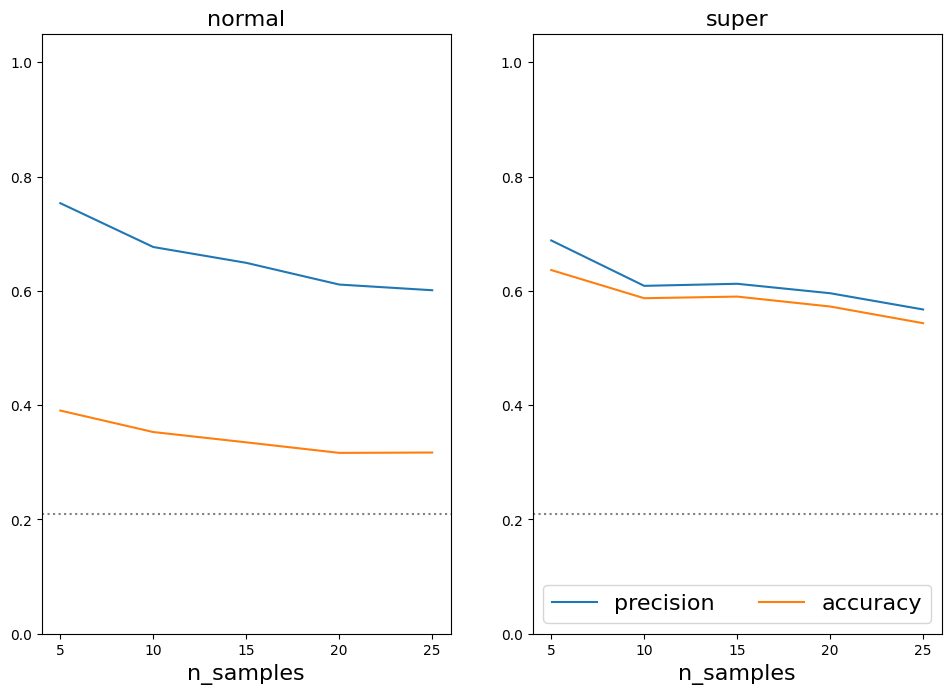

In [95]:
plot_acc_prec_summary(df_results, fontsize=16, compare_with=0.21)

In [96]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("n_samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    # sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("n_samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    # sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("n_samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0, 1.05)
    
    labels = []
    n_list = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        for n_sample, data in klass.groupby(by="n_samples"):
            n_list.append(n_sample)
            precs_by_n_sample.append(data["precision"].mean())
            accs_by_n_sample.append(data["accuracy"].mean())
        sub_prec.plot(n_list, precs_by_n_sample, label=l)
        sub_acc.plot(n_list, accs_by_n_sample, label=l)
        labels.append(l)
    # plt.xticks(n_list)
    plt.legend(labels, loc="lower center", bbox_to_anchor=(0, 1), ncol=5, fontsize=fontsize)
    
    # save images
    plt.savefig(f"./plots/{group_id_list[0]}/{strategy}-{verification}-{ex_id}.pdf")


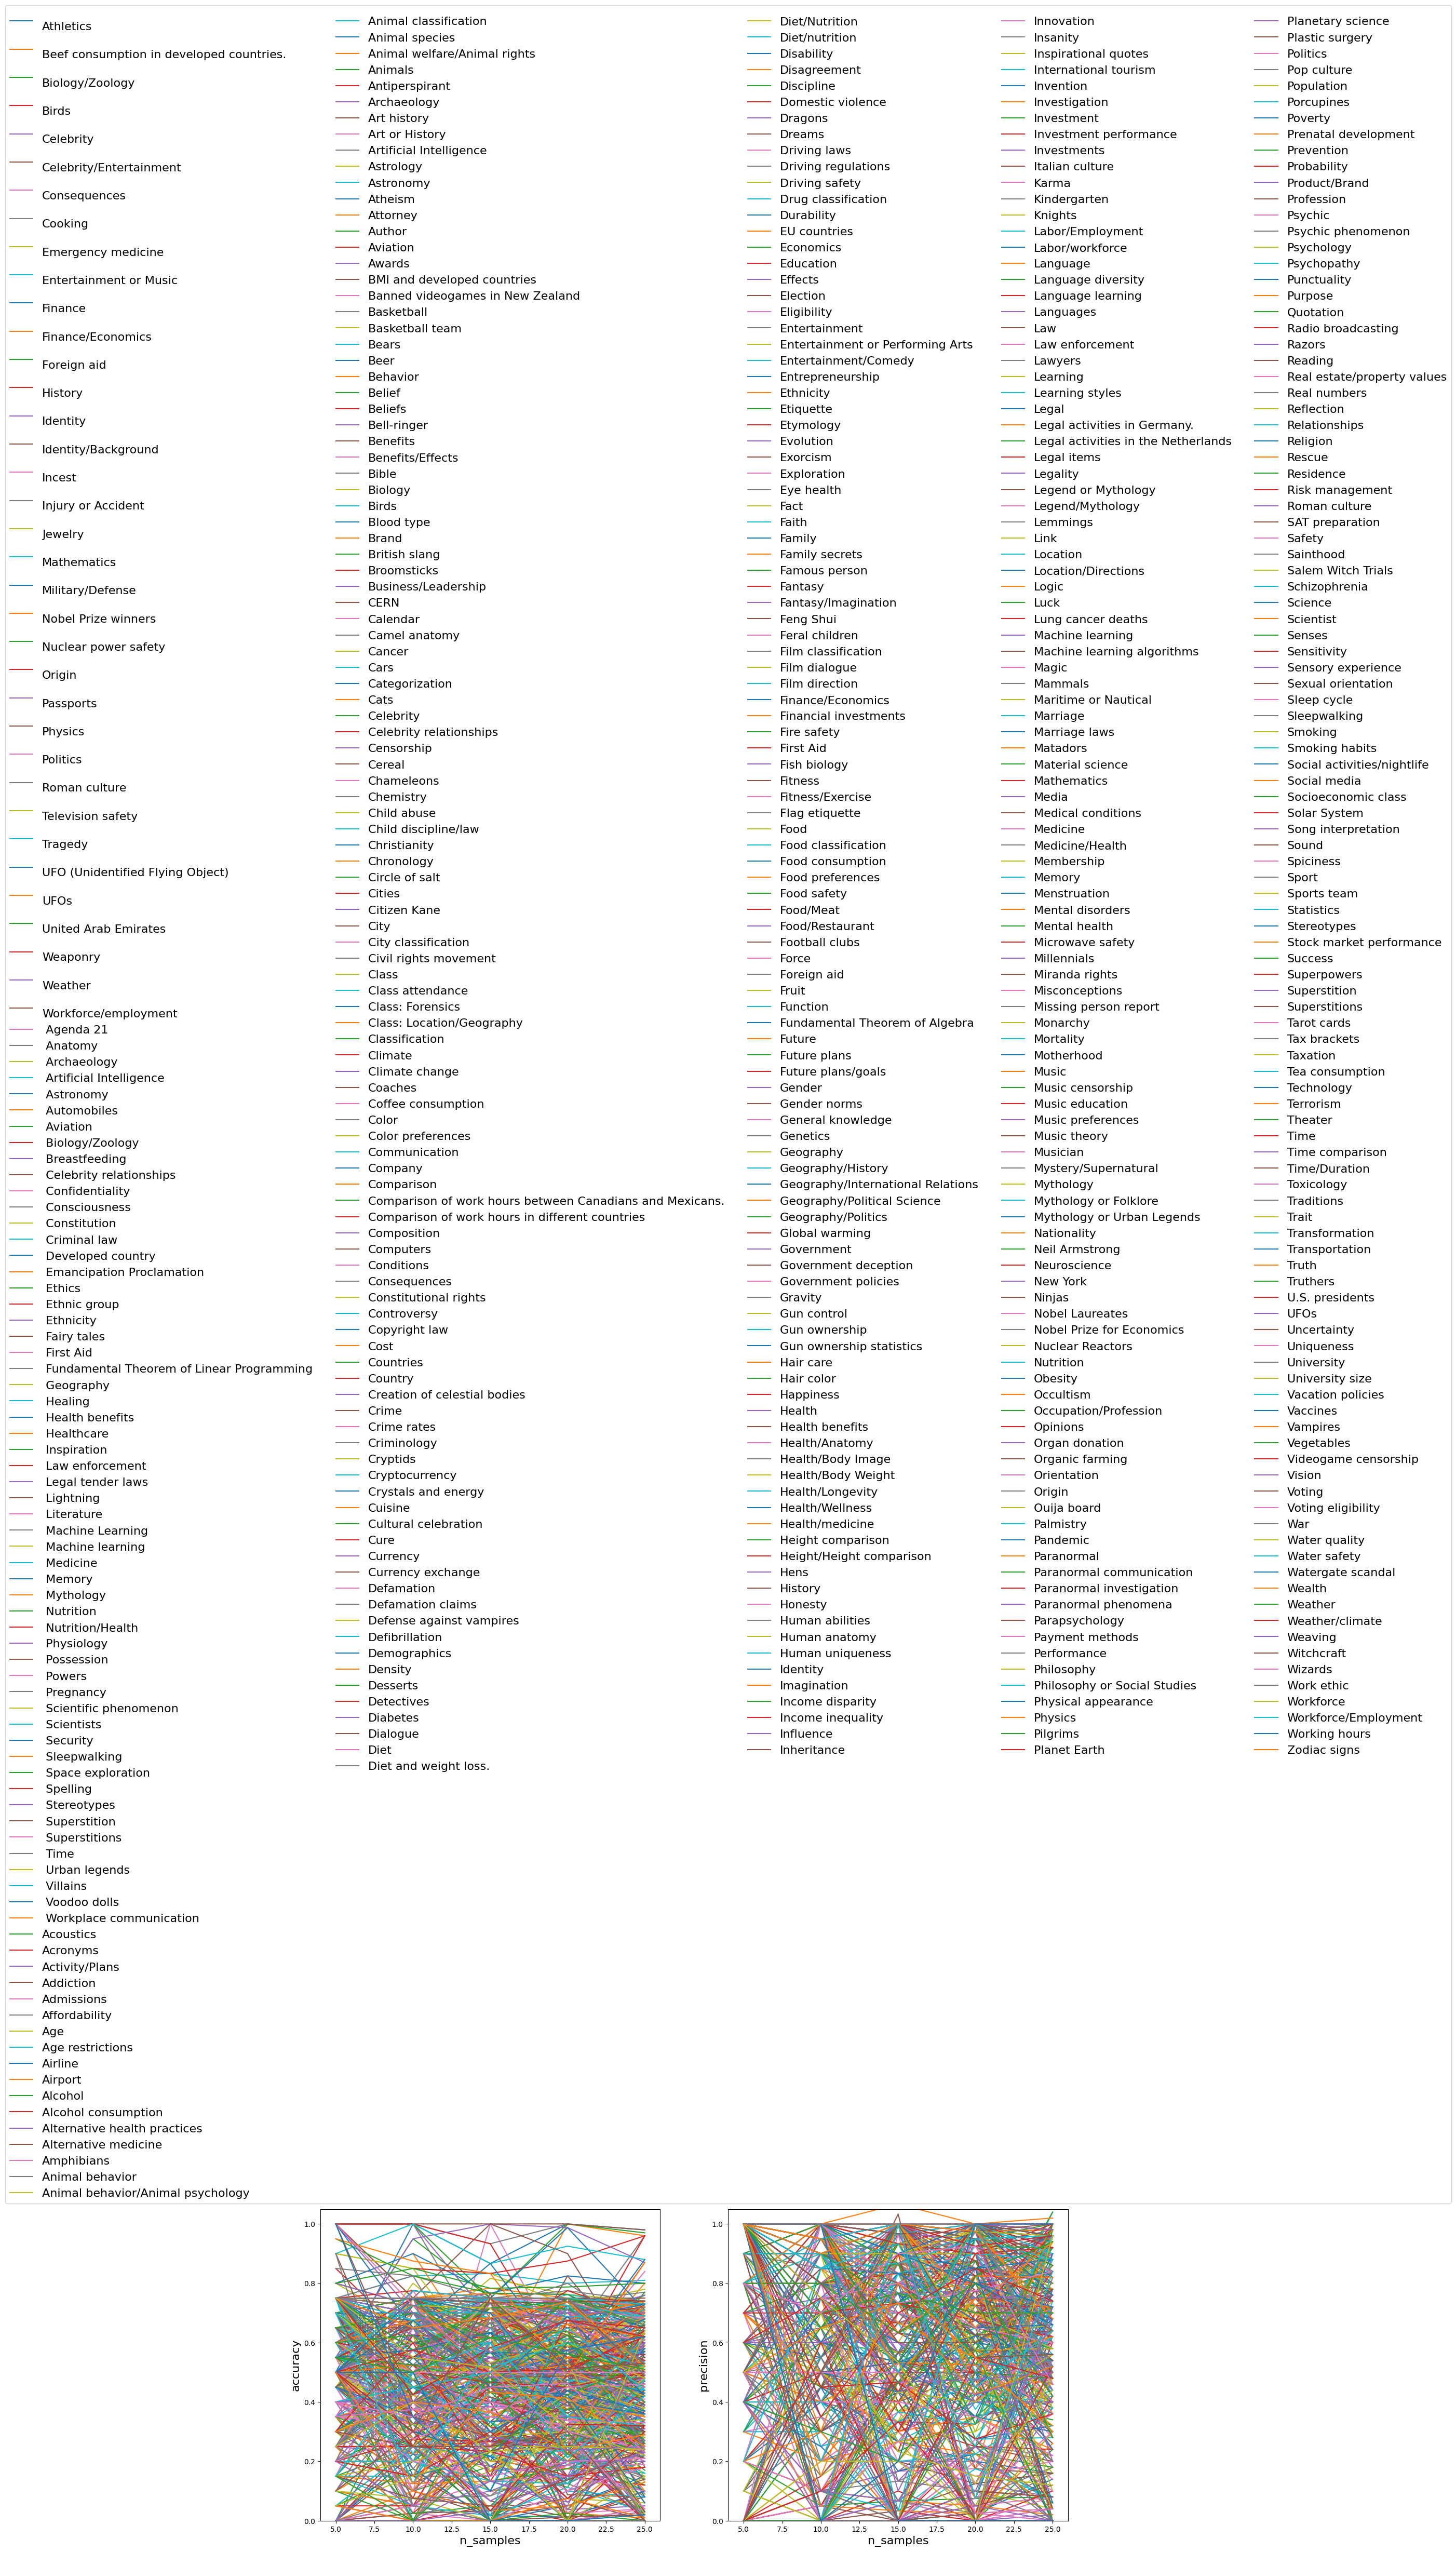

In [97]:
plot_acc_prec_by_verification(df_results, fontsize=16)